<a href="https://colab.research.google.com/github/SaiMudigonda/Saikumar_INFO5731_Spring2021/blob/main/In_class_exercise_07.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **The seventh in-class-exercise (20 points in total, 3/16/2021)**

Question description: In the last in-class-exercise (exercise-06), you collected the titles of 100 articles about data science, natural language processing, and machine learning. The 100 article titles will be used as the text corpus of this exercise. Perform the following tasks:

## (1) (8 points) Generate K topics by using LDA, the number of topics K should be decided by the coherence score, then summarize what are the topics. You may refer the code here: 

https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

In [33]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [34]:
import os
def install_java():
  !apt-get install -y openjdk-8-jdk-headless -qq > /dev/null
  os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
  !java -version
install_java()

openjdk version "11.0.10" 2021-01-19
OpenJDK Runtime Environment (build 11.0.10+9-Ubuntu-0ubuntu1.18.04)
OpenJDK 64-Bit Server VM (build 11.0.10+9-Ubuntu-0ubuntu1.18.04, mixed mode, sharing)


In [36]:
!pip install --upgrade gensim

Requirement already up-to-date: gensim in /usr/local/lib/python3.7/dist-packages (3.8.3)


In [37]:
import spacy.cli
spacy.cli.download("en")




✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.7/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.7/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')


In [38]:

import re
import numpy as np
import pandas as pd
from pprint import pprint
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import spacy
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [39]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [47]:
from google.colab import files
uploaded = files.upload()

Saving NLP titles extratct from website.csv to NLP titles extratct from website.csv


In [51]:
files = pd.read_csv("NLP titles extratct from website.csv",encoding = "ISO-8859-1")
files.head(10)

,Energy and policy considerations for deep learning in NLP
0,Jumping?NLP?curves: A review of natural langua...
1,BRAT: a web-based tool for?NLP-assisted text a...
2,Instance weighting for domain adaptation in?NLP
3,BERT rediscovers the classical?NLP?pipeline
4,Multiword expressions: A pain in the neck for?NLP
5,Scatter search and local?NLP?solvers: A multis...
6,FLAIR: An easy-to-use framework for state-of-t...
7,An LP/NLP?based branch and bound algorithm for...
8,"?Polo-like kinase 1 regulates?Nlp, a centrosom..."
9,Visualizing and understanding neural models in...


In [58]:
# Convert to list
data = files["Energy and policy considerations for deep learning in NLP"].values.tolist()
# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

pprint(data[:1])

['Jumping?NLP?curves: A review of natural language processing research']


In [59]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['jumping', 'nlp', 'curves', 'review', 'of', 'natural', 'language', 'processing', 'research']]


In [60]:
data_words = []
for line in data:
  data_words.append(gensim.utils.simple_preprocess(str(line), deacc=True))

In [61]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['jumping', 'nlp', 'curves', 'review', 'of', 'natural', 'language', 'processing', 'research']


/usr/local/lib/python3.7/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  Phrases detected in `sentences`. Return type depends on the `as_tuples` parameter.


In [64]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

    # Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['jump', 'curve', 'review', 'natural', 'language', 'processing', 'research']]


In [65]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1)]]


[[('curve', 1),
  ('jump', 1),
  ('language', 1),
  ('natural', 1),
  ('processing', 1),
  ('research', 1),
  ('review', 1)]]

In [66]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [67]:
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.041*"task" + 0.022*"language" + 0.022*"intensive" + 0.022*"annotate" + '
  '0.022*"generation" + 0.022*"twitt" + 0.022*"tweet" + 0.022*"relate" + '
  '0.022*"lifeline" + 0.022*"challenge"'),
 (1,
  '0.048*"problem" + 0.048*"state" + 0.048*"nlp" + 0.025*"survey" + '
  '0.025*"decoration" + 0.025*"optimum" + 0.025*"attention" + '
  '0.025*"mechanism" + 0.025*"introductory" + 0.025*"programming"'),
 (2,
  '0.037*"nlp" + 0.019*"use" + 0.019*"deep" + 0.019*"neural" + '
  '0.019*"classification" + 0.019*"topic" + 0.019*"approach" + '
  '0.019*"discussion" + 0.019*"sentiment" + 0.019*"recurrent"'),
 (3,
  '0.088*"nlp" + 0.034*"model" + 0.023*"task" + 0.023*"network" + 0.023*"text" '
  '+ 0.023*"adversarial" + 0.012*"framework" + 0.012*"application" + '
  '0.012*"base" + 0.012*"trigger"'),
 (4,
  '0.049*"nlp" + 0.033*"datum" + 0.017*"click" + 0.017*"induce" + '
  '0.017*"understand" + 0.017*"curve" + 0.017*"combine" + 0.017*"sojae" + '
  '0.017*"stream" + 0.017*"mooc"'),
 (5,
  '0.04

In [68]:
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -6.282465497434956

Coherence Score:  0.39965677239226877


In [72]:
!wget http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
!unzip mallet-2.0.8.zip

--2021-03-20 03:47:59--  http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
Resolving mallet.cs.umass.edu (mallet.cs.umass.edu)... 128.119.246.70
Connecting to mallet.cs.umass.edu (mallet.cs.umass.edu)|128.119.246.70|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16184794 (15M) [application/zip]
Saving to: ‘mallet-2.0.8.zip’

mallet-2.0.8.zip    100%[===================>]  15.43M  17.5MB/s    in 0.9s    

2021-03-20 03:48:00 (17.5 MB/s) - ‘mallet-2.0.8.zip’ saved [16184794/16184794]

Archive:  mallet-2.0.8.zip
   creating: mallet-2.0.8/
   creating: mallet-2.0.8/bin/
  inflating: mallet-2.0.8/bin/classifier2info  
  inflating: mallet-2.0.8/bin/csv2classify  
  inflating: mallet-2.0.8/bin/csv2vectors  
  inflating: mallet-2.0.8/bin/mallet  
  inflating: mallet-2.0.8/bin/mallet.bat  
  inflating: mallet-2.0.8/bin/mallethon  
  inflating: mallet-2.0.8/bin/prepend-license.sh  
  inflating: mallet-2.0.8/bin/svmlight2vectors  
  inflating: mallet-2.0.8/bin/text2classi

In [73]:

os.environ['MALLET_HOME'] = '/content/mallet-2.0.8'
mallet_path = '/content/mallet-2.0.8/bin/mallet' # update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=10, id2word=id2word)

In [74]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(0,
  [('understand', 0.10344827586206896),
   ('survey', 0.06896551724137931),
   ('barrier', 0.034482758620689655),
   ('train', 0.034482758620689655),
   ('freele', 0.034482758620689655),
   ('benchmark', 0.034482758620689655),
   ('nutrient', 0.034482758620689655),
   ('influence', 0.034482758620689655),
   ('transfer', 0.034482758620689655),
   ('datum', 0.034482758620689655)]),
 (1,
  [('model', 0.2631578947368421),
   ('embedding', 0.07894736842105263),
   ('introductory', 0.02631578947368421),
   ('overcome', 0.02631578947368421),
   ('boxer', 0.02631578947368421),
   ('probe', 0.02631578947368421),
   ('semantic', 0.02631578947368421),
   ('mooc', 0.02631578947368421),
   ('compliance', 0.02631578947368421),
   ('scatter', 0.02631578947368421)]),
 (2,
  [('base', 0.1590909090909091),
   ('search', 0.045454545454545456),
   ('problem', 0.045454545454545456),
   ('bind', 0.022727272727272728),
   ('global', 0.022727272727272728),
   ('good', 0.022727272727272728),
   ('availabi

In [81]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [82]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)

In [83]:
coherence_values

[0.7115398446855449,
 0.7595015267200526,
 0.7685162164817332,
 0.7396024294532898,
 0.7176598838323203,
 0.6966943154449778,
 0.6855931515889271]

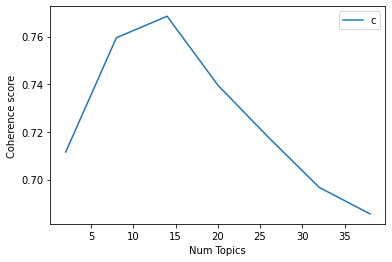

In [87]:
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

Summarizing topics:

NLP to extract solution for Medical Plagarism

Computer unified assistance for statistical biomedicine architecture

Generates current engineering software models using NLP

NLP for text mining in helath and medicine industry

Processes medical information using NLP

## (2) (8 points) Generate K topics by using LSA, the number of topics K should be decided by the coherence score, then summarize what are the topics. You may refer the code here:

https://www.datacamp.com/community/tutorials/discovering-hidden-topics-python

In [89]:
number_of_topics = 6


In [90]:
def prepare_corpus(doc_clean):
    """
    Input  : clean document
    Purpose: create term dictionary of our courpus and Converting list of documents (corpus) into Document Term Matrix
    Output : term dictionary and Document Term Matrix
    """
    # Creating the term dictionary of our courpus, where every unique term is assigned an index. dictionary = corpora.Dictionary(doc_clean)
    dictionary = corpora.Dictionary(doc_clean)
    # Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
    doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]
    # generate LDA model
    return dictionary,doc_term_matrix

In [91]:
def create_gensim_lsa_model(doc_clean,number_of_topics,words):
    """
    Input  : clean document, number of topics and number of words associated with each topic
    Purpose: create LSA model using gensim
    Output : return LSA model
    """
    dictionary,doc_term_matrix=prepare_corpus(doc_clean)
    # generate LSA model
    lsamodel = LsiModel(doc_term_matrix, num_topics=number_of_topics, id2word = dictionary)  # train model
    print(lsamodel.print_topics(num_topics=number_of_topics, num_words=words))
    return lsamodel

In [93]:
def compute_coherence_values_lsa(dictionary, doc_term_matrix, doc_clean, start, limit, step):
   
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        # generate LSA model
        model = LsiModel(doc_term_matrix, num_topics=number_of_topics, id2word = dictionary)  # train model
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=doc_clean, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

model_list_lsa, coherence_lsa = compute_coherence_values_lsa(id2word,corpus,data_lemmatized,start=2,limit=40,step=6)

for m, cv in zip(x,coherence_lsa):
  print("Num Topics=",m," has coherence value of", round(cv,4))

Num Topics= 2  has coherence value of 0.3857
Num Topics= 8  has coherence value of 0.4092
Num Topics= 14  has coherence value of 0.352
Num Topics= 20  has coherence value of 0.4092
Num Topics= 26  has coherence value of 0.3857
Num Topics= 32  has coherence value of 0.3601
Num Topics= 38  has coherence value of 0.4092


In [94]:

# Select the model and print the topics
optimal_model_lsa = model_list_lsa[5]
model_topics_lsa = optimal_model_lsa.show_topics(formatted=False)
pprint(optimal_model_lsa.print_topics(num_words=10))

[(0,
  '-0.867*"nlp" + -0.204*"model" + -0.112*"task" + -0.110*"use" + '
  '-0.103*"large" + -0.103*"scale" + -0.072*"network" + -0.070*"optimization" '
  '+ -0.069*"deep" + -0.066*"word"'),
 (1,
  '0.602*"model" + 0.363*"base" + 0.242*"arabic" + 0.207*"embedding" + '
  '-0.168*"nlp" + 0.163*"set" + 0.153*"task" + 0.132*"language" + 0.132*"word" '
  '+ 0.116*"aravec"'),
 (2,
  '-0.505*"base" + -0.322*"use" + -0.251*"automate" + 0.240*"model" + '
  '-0.155*"extraction" + -0.145*"approach" + -0.143*"network" + '
  '-0.142*"semantic" + -0.132*"construction" + -0.132*"document"'),
 (3,
  '-0.291*"network" + -0.274*"neural" + -0.271*"use" + -0.245*"model" + '
  '-0.237*"approach" + -0.226*"deep" + -0.206*"arabic" + -0.173*"sentiment" + '
  '-0.173*"discussion" + -0.173*"recurrent"'),
 (4,
  '-0.353*"task" + -0.267*"text" + -0.240*"overcome" + -0.240*"barrier" + '
  '-0.240*"clinical" + -0.240*"creative" + -0.240*"additional" + '
  '-0.240*"share" + -0.240*"need" + -0.240*"solution"'),
 (5,


In [ ]:
for no_of_topics, cv in zip(range(2, 60, 6), coherence_values_lsa):
  print("Num Topics:", no_of_topics, " - Coherence Value:", round(cv, 4))

## (3) (4 points) Compare the results generated by the two topic modeling algorithms, which one is better? You should explain the reasons in details.

In [ ]:
# Write your answer here (no code needed for this question)
Latent Semantic Analysis has lower accuracy than Latent Dirichlet allocation has better accuracy. By comparing the above values of coherences valjues we can understand that LSA is much faster to train then LDA.
LDA overcomes all the drawbacks of LSA. 